In [1]:
import pandas as pd
import numpy as np
import datetime
import math
import os
import matplotlib.pyplot as plt
from pylab import rcParams

plt.style.use('ggplot')
%pylab inline --no-import-all

#風力発電初期値
Pr=2.3 #定格電力
V_CIN=2.5 #カットイン風速
V_rat=20 #
V_CO=20 #カットアウト風速
H=30.5 #高さ
H_top=80 #風速計測の高さ（高い）
H_ref=10 #風速計測の高さ（低い）
atm_pre0=1.225 #基準大気圧
total_cost = 1575000 #コスト[yen/unit]
Op_year = 10 #稼動年数
cost = (total_cost/(Op_year*365*24)) #コスト[yen/hour/unit]

Populating the interactive namespace from numpy and matplotlib


In [2]:
pwd()

'/home/yuichiro/Miniconda/Weather/GribToCSV'

# Set or Modify parameters below!!

In [3]:
#インプットデータ
year="2019"
month="04"
day="23"
time="120000"
file_dir_path="Output_CSV/"+year+"/"+month+"/"+day
#開始日本時間（UTC+9）
start_TimeJP ='2019-04-23 12:00'
finish_TimeJP ='2019-04-25 15:00'

In [4]:
###UTC time to Japan in time:000000
TimeJP = pd.date_range(start_TimeJP,finish_TimeJP,freq='H')
TimeJP.columns = ['Datetime in Japan']
Date =pd.DataFrame({'DateTime': TimeJP.values})
#Date
Date['DateTime'] = pd.to_datetime(Date['DateTime'])
#Date.dtypes
if len(Date)==52:
    print("OK")
else:
    print("Error")
    print(len(Date))

OK


In [5]:
Date['Date']=Date['DateTime']
Date['Year']=Date['DateTime'] .dt.year
Date['Month']=Date['DateTime'] .dt.month
Date['Day']=Date['DateTime'] .dt.day
Date['Hour']=Date['DateTime'] .dt.hour

In [6]:
input_tempFH_0015 = pd.read_csv(file_dir_path+'/FH_00-15_temperature'+year+'_'+month+'_'+day+'_'+time+'.csv')
input_tempFH_1633 = pd.read_csv(file_dir_path+'/FH_16-33_temperature'+year+'_'+month+'_'+day+'_'+time+'.csv')
input_tempFH_3439 = pd.read_csv(file_dir_path+'/FH_34-39_temperature'+year+'_'+month+'_'+day+'_'+time+'.csv')
input_tempFH_4051 = pd.read_csv(file_dir_path+'/FH_40-51_temperature'+year+'_'+month+'_'+day+'_'+time+'.csv')

input_temp = pd.concat([input_tempFH_0015,input_tempFH_1633,input_tempFH_3439,\
                       input_tempFH_4051],axis=1).T.drop(["index","lons","lats"])
input_temp.columns = ['temperature']
input_temp=input_temp.reset_index()
#input_temp

In [7]:
input_UwindFH_0015 = pd.read_csv(file_dir_path+'/FH_00-15_Uwind'+year+'_'+month+'_'+day+'_'+time+'.csv')
input_UwindFH_1633 = pd.read_csv(file_dir_path+'/FH_16-33_Uwind'+year+'_'+month+'_'+day+'_'+time+'.csv')
input_UwindFH_3439 = pd.read_csv(file_dir_path+'/FH_34-39_Uwind'+year+'_'+month+'_'+day+'_'+time+'.csv')
input_UwindFH_4051 = pd.read_csv(file_dir_path+'/FH_40-51_Uwind'+year+'_'+month+'_'+day+'_'+time+'.csv')

input_Uwind = pd.concat([input_UwindFH_0015,input_UwindFH_1633,input_UwindFH_3439,\
                       input_UwindFH_4051],axis=1).T.drop(["index","lons","lats"]).apply(abs)
input_Uwind.columns = ['Uwind']

input_Uwind=input_Uwind.reset_index()

In [8]:
input_VwindFH_0015 = pd.read_csv(file_dir_path+'/FH_00-15_Vwind'+year+'_'+month+'_'+day+'_'+time+'.csv')
input_VwindFH_1633 = pd.read_csv(file_dir_path+'/FH_16-33_Vwind'+year+'_'+month+'_'+day+'_'+time+'.csv')
input_VwindFH_3439 = pd.read_csv(file_dir_path+'/FH_34-39_Vwind'+year+'_'+month+'_'+day+'_'+time+'.csv')
input_VwindFH_4051 = pd.read_csv(file_dir_path+'/FH_40-51_Vwind'+year+'_'+month+'_'+day+'_'+time+'.csv')

input_Vwind = pd.concat([input_VwindFH_0015,input_VwindFH_1633,input_VwindFH_3439,\
                       input_VwindFH_4051],axis=1).T.drop(["index","lons","lats"]).apply(abs)
input_Vwind.columns = ['Vwind']
input_Vwind=input_Vwind.reset_index()

In [9]:
input_radFH_0015 = pd.read_csv(file_dir_path+'/FH_00-15_radiation'+year+'_'+month+'_'+day+'_'+time+'.csv')
input_radFH_1633 = pd.read_csv(file_dir_path+'/FH_16-33_radiation'+year+'_'+month+'_'+day+'_'+time+'.csv')
input_radFH_3439 = pd.read_csv(file_dir_path+'/FH_34-39_radiation'+year+'_'+month+'_'+day+'_'+time+'.csv')
input_radFH_4051 = pd.read_csv(file_dir_path+'/FH_40-51_radiation'+year+'_'+month+'_'+day+'_'+time+'.csv')

input_rad = pd.concat([input_radFH_0015,input_radFH_1633,input_radFH_3439,\
                       input_radFH_4051],axis=1).T.drop(["index","lons","lats"])
input_rad.columns = ['radiation']
input_rad=input_rad.reset_index()

# Wind Calc

In [10]:
##calc wind
wind10 = np.square(input_Uwind['Uwind'].values)+np.square(input_Vwind['Vwind'].values)
wind10 = np.sqrt(wind10)
wind10 =pd.DataFrame({'wind': wind10})
wind10.columns = ['wind_10m[m/s]']
#ind10

In [11]:
forecast=pd.concat([Date,wind10,input_temp,input_rad,input_Uwind,input_Vwind],axis=1,sort=False)

In [12]:
#Using Vz = Vr(Z / Zr)^(1/n) n=4

wind30_values = wind10.values*((H/10)**(1/3))
wind30 = pd.DataFrame( {'wind_30m[m/s]': wind30_values.reshape(-1,) })

In [13]:
Pwt_values=(np.where((V_rat<=wind30_values) & (wind30_values <= V_CO), Pr,\
              np.where((V_CIN<=wind30_values) & (wind30_values <= V_rat), \
                       Pr*(wind30_values-V_CIN)/(V_rat-V_CIN),0 )))
Pwt = pd.DataFrame( {'wind output[kWh]': Pwt_values.reshape(-1,) })

In [14]:
forecast=pd.concat([forecast,wind30,Pwt],axis=1,sort=False)
#forecast=forecast.set_index('DateTime')
forecast

,DateTime,Date,Year,Month,Day,Hour,wind_10m[m/s],index,temperature,index,radiation,index,Uwind,index,Vwind,wind_30m[m/s],wind output[kWh]
0,2019-04-23 12:00:00,2019-04-23 12:00:00,2019,4,23,12,3.077222,temperature FH0,18.196584,radiation FH0-1W/m2(avg),0.000000,Uwind FH0m/s,2.256428,Vwind FH0m/s,2.092327,4.462643,0.257947
1,2019-04-23 13:00:00,2019-04-23 13:00:00,2019,4,23,13,2.694236,temperature FH1,18.470083,radiation FH1-2W/m2(avg),0.000000,Uwind FH1m/s,2.085671,Vwind FH1m/s,1.705544,3.907229,0.184950
2,2019-04-23 14:00:00,2019-04-23 14:00:00,2019,4,23,14,2.484397,temperature FH2,18.518667,radiation FH2-3W/m2(avg),0.000000,Uwind FH2m/s,1.814962,Vwind FH2m/s,1.696509,3.602918,0.144955
3,2019-04-23 15:00:00,2019-04-23 15:00:00,2019,4,23,15,2.496047,temperature FH3,18.862020,radiation FH3-4W/m2(avg),0.000000,Uwind FH3m/s,1.401853,Vwind FH3m/s,2.065202,3.619812,0.147175
4,2019-04-23 16:00:00,2019-04-23 16:00:00,2019,4,23,16,2.351890,temperature FH4,18.889425,radiation FH4-5W/m2(avg),0.000000,Uwind FH4m/s,1.405579,Vwind FH4m/s,1.885666,3.410753,0.119699
5,2019-04-23 17:00:00,2019-04-23 17:00:00,2019,4,23,17,2.588599,temperature FH5,19.005636,radiation FH5-6W/m2(avg),0.000000,Uwind FH5m/s,1.282409,Vwind FH5m/s,2.248616,3.754033,0.164816
6,2019-04-23 18:00:00,2019-04-23 18:00:00,2019,4,23,18,3.061397,temperature FH6,19.245535,radiation FH6-7W/m2(avg),0.000000,Uwind FH6m/s,1.356512,Vwind FH6m/s,2.744453,4.439692,0.254931
7,2019-04-23 19:00:00,2019-04-23 19:00:00,2019,4,23,19,3.574850,temperature FH7,19.465780,radiation FH7-8W/m2(avg),0.000000,Uwind FH7m/s,1.333967,Vwind FH7m/s,3.316637,5.184311,0.352795
8,2019-04-23 20:00:00,2019-04-23 20:00:00,2019,4,23,20,3.453941,temperature FH8,19.662863,radiation FH8-9W/m2(avg),1.437500,Uwind FH8m/s,1.118949,Vwind FH8m/s,3.267670,5.008968,0.329750
9,2019-04-23 21:00:00,2019-04-23 21:00:00,2019,4,23,21,2.890500,temperature FH9,19.848837,radiation FH9-10W/m2(avg),41.260180,Uwind FH9m/s,0.852270,Vwind FH9m/s,2.761997,4.191856,0.222358


# Solar calc

In [15]:
#太陽光発電初期値

#インプットデータ
#input_rad = pd.read_csv('rad.csv')#encordingはUTF-8なので注意 unitは、MJ/m2
input_csv_parameter = pd.read_csv('PV_input_parameter.csv')

In [16]:
#1列目以外を抽出
input_csv_parameter = input_csv_parameter.iloc[:, [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]]

Gsc = float(input_csv_parameter.iat[0,0])#float(1.367)#the solar constant [1.367 kW/m2]
Gt_NOCT = float(input_csv_parameter.iat[0,1]) #the solar radiation at which the NOCT is defined [0.8 kW/m2]
Ta_NOCT = float(input_csv_parameter.iat[0,2])+273.15 #the ambient temperature at which the NOCT is defined [20°C]
Tc_NOCT = float(input_csv_parameter.iat[0,3])+273.15 #the nominal operating cell temperature [°C]
Tc_STC = float(input_csv_parameter.iat[0,4])+273.15 #the PV cell temperature under standard test conditions [25°C]

YPV = float(input_csv_parameter.iat[0,6]) #the rated capacity of the PV array, meaning its power output under standard test conditions [kW]
ap = float(input_csv_parameter.iat[0,7]) #Module Efficiency(Pmax)[%/℃]
beta= float(input_csv_parameter.iat[0,8])  #the slope of the surface [°]
eta_c = float(input_csv_parameter.iat[0,9]) #the solar absorptance and the solar transmittance[%]
fpv = float(input_csv_parameter.iat[0,10]) #the PV derating factor [%]
ganma = float(input_csv_parameter.iat[0,11]) #the azimuth of the surface [°]
lam=float(input_csv_parameter.iat[0,12])#the longitude [°]
phi=float(input_csv_parameter.iat[0,13])#the latitude [°]
rho_g = float(input_csv_parameter.iat[0,14]) # the ground reflectance, which is also called the albedo [%]
tau_a = float(input_csv_parameter.iat[0,15]) #the solar absorptance and the solar transmittance[%]
_Gt_STC =float(1) #the incident radiation at standard test conditions [1 kW/m2]
UL = (tau_a*Gt_NOCT)/(Tc_NOCT-Ta_NOCT)
#UL = float(input_csv_parameter.iat[0,5])
total_cost = float(input_csv_parameter.iat[0,16]) #total cost
Op_year = float(input_csv_parameter.iat[0,17]) #oparation year
cost = total_cost/(Op_year*365*24)#cost[yen/kW/h]

In [17]:
input_csv_parameter

,Gsc,Gt_NOCT,Ta_NOCT,Tc_NOCT,Tc_STC,UL,YPV,ap,beta,eta_c,fpv,ganma,lam,phi,rho_g,tau_a,total_cost,Op_year
0,1.367,0.8,20,44,25,3,194.44,-0.00258,33,0.194,0.8,0,130.25,33.349,0.2,0.9,199165,15


In [18]:
#ωの計算
forecast['ts'] = forecast['Hour']
forecast['ω'] = (forecast['ts'].values - 12 )*15#degree
forecast['n'] = Date['DateTime'] .dt.dayofyear

In [19]:
forecast['δ the solar declination']=23.45*np.sin(np.deg2rad(360*(284+forecast['n'].values)/365))#degree

delta=forecast['δ the solar declination'].values#degree

In [20]:
#角度をdeg2rad
omega = np.deg2rad(forecast['ω'].values)#rad
delta =np.deg2rad(delta)#rad
phi =math.radians(phi)#rad
beta =math.radians(beta)#rad
ganma =math.radians(ganma)#rad
lam =math.radians(lam)#rad

#cosθの計算
forecast['cosθ'] = np.sin(delta)*math.sin(phi)*math.cos(beta)\
                    -np.sin(delta)*math.cos(phi)*math.sin(beta)*math.cos(ganma)\
                    +np.cos(delta)*math.cos(phi)*math.cos(beta)*np.cos(omega)\
                    +np.cos(delta)*math.sin(phi)*math.sin(beta)*math.cos(ganma)*np.cos(omega)\
                    +np.cos(delta)*math.sin(beta)*math.sin(ganma)*np.sin(omega)
                    
cos_theta = forecast['cosθ'].values

In [21]:
#θの計算
forecast['θ(radian)'] = np.arccos(forecast['cosθ'].values)#rad

forecast['θ(degree)'] = np.rad2deg(forecast['θ(radian)'].values)#degree

Theta_deg = forecast['θ(radian)'].values#rad

#cosθzの計算
forecast['cosθz'] =math.cos(phi)*np.cos(delta)*np.cos(omega)\
                        +math.sin(phi)*np.sin(delta)

cos_theta_z = forecast['cosθz'].values

forecast['θz(radian)'] = np.arccos(forecast['cosθz'].values)#rad

forecast['θz(degree)'] = np.rad2deg(forecast['θz(radian)'].values)#degree

Theta_z_deg = forecast['θz(radian)'].values#rad

#theta degree ndarray
theta = forecast['θ(radian)'].values#rad

#theta degree ndarray
theta_z = forecast['θz(radian)'].values#rad

#decimals=1で小数点第2位を四捨五入する
cos_theta = np.round(cos_theta, decimals=1)
cos_theta_z = np.round(cos_theta_z, decimals=1)
Theta_deg =np.round(Theta_deg, decimals=0)
Theta_deg_z = np.round(Theta_z_deg, decimals=0)

cos_theta = np.cos(Theta_deg)
cos_theta_z = np.cos(Theta_z_deg)
forecast[:10]

,DateTime,Date,Year,Month,Day,Hour,wind_10m[m/s],index,temperature,index,...,ts,ω,n,δ the solar declination,cosθ,θ(radian),θ(degree),cosθz,θz(radian),θz(degree)
0,2019-04-23 12:00:00,2019-04-23 12:00:00,2019,4,23,12,3.077222,temperature FH0,18.196584,radiation FH0-1W/m2(avg),...,12,0,113,12.274096,0.978419,0.208132,11.925096,0.933111,0.367826,21.074904
1,2019-04-23 13:00:00,2019-04-23 13:00:00,2019,4,23,13,2.694236,temperature FH1,18.470083,radiation FH1-2W/m2(avg),...,13,15,113,12.274096,0.945124,0.332823,19.069338,0.905298,0.438715,25.136509
2,2019-04-23 14:00:00,2019-04-23 14:00:00,2019,4,23,14,2.484397,temperature FH2,18.518667,radiation FH2-3W/m2(avg),...,14,30,113,12.274096,0.847509,0.559522,32.058260,0.823755,0.602793,34.537503
3,2019-04-23 15:00:00,2019-04-23 15:00:00,2019,4,23,15,2.496047,temperature FH3,18.862020,radiation FH3-4W/m2(avg),...,15,45,113,12.274096,0.692226,0.806228,46.193450,0.694039,0.803712,46.049310
4,2019-04-23 16:00:00,2019-04-23 16:00:00,2019,4,23,16,2.351890,temperature FH4,18.889425,radiation FH4-5W/m2(avg),...,16,60,113,12.274096,0.489857,1.058871,60.668834,0.524990,1.018094,58.332462
5,2019-04-23 17:00:00,2019-04-23 17:00:00,2019,4,23,17,2.588599,temperature FH5,19.005636,radiation FH5-6W/m2(avg),...,17,75,113,12.274096,0.254193,1.313783,75.274221,0.328127,1.236476,70.844856
6,2019-04-23 18:00:00,2019-04-23 18:00:00,2019,4,23,18,3.061397,temperature FH6,19.245535,radiation FH6-7W/m2(avg),...,18,90,113,12.274096,0.001295,1.569501,89.925807,0.116868,1.453661,83.288624
7,2019-04-23 19:00:00,2019-04-23 19:00:00,2019,4,23,19,3.574850,temperature FH7,19.465780,radiation FH7-8W/m2(avg),...,19,105,113,12.274096,-0.251603,1.825133,104.572408,-0.094391,1.665328,95.416290
8,2019-04-23 20:00:00,2019-04-23 20:00:00,2019,4,23,20,3.453941,temperature FH8,19.662863,radiation FH8-9W/m2(avg),...,20,120,113,12.274096,-0.487267,2.079754,119.161102,-0.291254,1.866333,106.933027
9,2019-04-23 21:00:00,2019-04-23 21:00:00,2019,4,23,21,2.890500,temperature FH9,19.848837,radiation FH9-10W/m2(avg),...,21,135,113,12.274096,-0.689636,2.331782,133.601291,-0.460303,2.049133,117.406673


In [22]:
#Gon(the extraterrestrial normal radiation)[kW/m2]の計算
forecast['Gon(the extraterrestrial normal radiation)[kW/m2]'] \
=Gsc*(1+0.033*np.cos(np.deg2rad(360*forecast['n'].values/365)))#np.deg2rad

Gon =forecast['Gon(the extraterrestrial normal radiation)[kW/m2]'].values

#Go(the extraterrestrial horizontal radiation [kW/m2])の計算
forecast['Go(the extraterrestrial horizontal radiation)[kW/m2]'] \
=Gon*np.abs(cos_theta_z)

Go = forecast['Go(the extraterrestrial horizontal radiation)[kW/m2]'] .values

In [23]:
#_Go(the extraterrestrial horizontal radiation averaged over the time step )[kW/m2]の計算

def step_minus(x):  #再帰関数　引数[2]-引数[1] ndarrayで返す ndarrayを引数
    x = list(x)
    y = [0]
    y.extend(x) #引数2
    x.extend([0]) #引数1
    y = np.array(y)
    x = np.array(x)
    ans = y - x
    return ans[1:]#[1:]or [:8760]


forecast['_Go(the extraterrestrial horizontal radiation averaged over the time step )[kW/m2]'] \
=(12/np.pi)*Gon*np.abs(np.cos(phi)*np.cos(delta)*step_minus(np.sin(omega))\
+((np.pi/180)*step_minus(omega)*np.sin(phi)*np.sin(delta)))

_Go = forecast['_Go(the extraterrestrial horizontal radiation averaged over the time step )[kW/m2]'] 

###start modified

In [24]:
forecast['the global horizontal radiation[kW/m2]']=\
forecast['radiation'].values/1000

_G = forecast['the global horizontal radiation[kW/m2]'].values
forecast['the global horizontal radiation[kW/m2]'] = _G 

In [25]:
#ktの計算
forecast['kt(the clearness index)'] =_G/_Go #_G2
kt = np.abs(forecast['kt(the clearness index)'].values)

_Go=kt/_G

#_Gdの計算
#２の３乗#累乗np.power(2, 3)
def if_kt(x):
    x = np.abs(x)
    ans = np.where(x>=0.8,0.165,np.where(x < 0.22, 1-0.09*x,0.95511-0.1604*x+4.388*x*x-16.638*x*x*x+12.336*x*x*x*x))
    return ans

forecast['_Gd(the diffuse radiation)[kW/m2]']=_G*if_kt(kt)
_Gd = forecast['_Gd(the diffuse radiation)[kW/m2]'].values

#_Gb(the beam radiation)の計算
forecast['_Gb(the beam radiation)[kW/m2]']=_G-_Gd

_Gb = forecast['_Gb(the beam radiation)[kW/m2]'].values

#_G
forecast['_G']=_Gd+_Gb

/home/yuichiro/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/home/yuichiro/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()
/home/yuichiro/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()


In [26]:
#Rbの計算
#input_data['Rb']= cos_theta/cos_theta_z
forecast['Rb']= np.abs(forecast['cosθ'].values/forecast['cosθz'].values)

#thetaの計算がjupyterだとうまくいかない泣
#input_data['Rb']=Rb
Rb = forecast['Rb'].values

#発散の処理 要考察 yを超えるとzになる　
def div(x,y,z):
    x = abs(x)
    ans = np.where(x>y,z,x)
    return ans
#Rb = div(Rb,3,3)
#input_data['Rb']= div(Rb,3,3)
forecast['Rb']= Rb

#Afの計算
forecast['Af']=_Gb/_Go #_G2

Af = forecast['Af'].values

#fの計算
forecast['f']=np.sqrt(_Gb/_G) #_G2
    #欠損値を0で置き換える
forecast=forecast.fillna(0)
f = forecast['f'].values                         

/home/yuichiro/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


In [27]:
def sin3(x):
    return math.sin(x)*math.sin(x)*math.sin(x)

#_Gtの計算#２の３乗#累乗np.power(2, 3) np.power(np.sin(beta/2),3) or def 3sin(x)
_Gt=(_Gb+_Gd*Af)*Rb\
                +(_Gd*(1-Af)*((1+math.cos(beta))/2)\
                *np.abs(1+f*sin3(beta/2)))\
                +(_G*rho_g*((1-math.cos(beta))/2))
_Gt[np.isnan(_Gt)] = 0
        
forecast['_Gt']  = _Gt


In [28]:
#Tc(the PV cell temperature [°C])の計算
forecast['temperature[K]']=forecast['temperature']+ 273.15
Ta = forecast['temperature[K]'].values


#input_data['Tc(the PV cell temperature)[°C]']\
#= Ta+_Gt*(tau_a/UL)*(1-eta_c/tau_a)

forecast['Tc(the PV cell temperature)[K]']\
= Ta+_Gt*((Tc_NOCT-Ta_NOCT)/Gt_NOCT)*(1-eta_c/tau_a)

Tc = forecast['Tc(the PV cell temperature)[K]'].values

forecast['Tc(the PV cell temperature)[°C]']=forecast['Tc(the PV cell temperature)[K]']-273.15

#Ppv(the output of the PV array)[kW]の計算   #発散の処理div(x)を使用
#input_data['Ppv(the output of the PV array)[Wh]']\
#=div(YPV*fpv*(_Gt/_Gt_STC)*np.abs((1+ap*(Tc-Tc_STC))), YPV,YPV)

#Ppv(the output of the PV array)[kW]の計算   #発散の処理div(x)を使用2
forecast['Ppv(the output of the PV array)[Wh]']\
=YPV*fpv*(_Gt/_Gt_STC)*np.abs((1+ap*(Tc-Tc_STC)))

Ppv = forecast['Ppv(the output of the PV array)[Wh]'].values

#input_data['Left'] = YPV*fpv*(_Gt/_Gt_STC)
#input_data['Right'] =np.abs((1+ap*(Tc-Tc_STC)))

forecast[:10]

,DateTime,Date,Year,Month,Day,Hour,wind_10m[m/s],index,temperature,index,...,_Gb(the beam radiation)[kW/m2],_G,Rb,Af,f,_Gt,temperature[K],Tc(the PV cell temperature)[K],Tc(the PV cell temperature)[°C],Ppv(the output of the PV array)[Wh]
0,2019-04-23 12:00:00,2019-04-23 12:00:00,2019,4,23,12,3.077222,temperature FH0,18.196584,radiation FH0-1W/m2(avg),...,0.000000e+00,0.000000,1.048555,0.000000e+00,0.000000,0.000000,291.346584,291.346584,18.196584,0.000000
1,2019-04-23 13:00:00,2019-04-23 13:00:00,2019,4,23,13,2.694236,temperature FH1,18.470083,radiation FH1-2W/m2(avg),...,0.000000e+00,0.000000,1.043992,0.000000e+00,0.000000,0.000000,291.620083,291.620083,18.470083,0.000000
2,2019-04-23 14:00:00,2019-04-23 14:00:00,2019,4,23,14,2.484397,temperature FH2,18.518667,radiation FH2-3W/m2(avg),...,0.000000e+00,0.000000,1.028836,0.000000e+00,0.000000,0.000000,291.668667,291.668667,18.518667,0.000000
3,2019-04-23 15:00:00,2019-04-23 15:00:00,2019,4,23,15,2.496047,temperature FH3,18.862020,radiation FH3-4W/m2(avg),...,0.000000e+00,0.000000,0.997387,0.000000e+00,0.000000,0.000000,292.012020,292.012020,18.862020,0.000000
4,2019-04-23 16:00:00,2019-04-23 16:00:00,2019,4,23,16,2.351890,temperature FH4,18.889425,radiation FH4-5W/m2(avg),...,0.000000e+00,0.000000,0.933079,0.000000e+00,0.000000,0.000000,292.039425,292.039425,18.889425,0.000000
5,2019-04-23 17:00:00,2019-04-23 17:00:00,2019,4,23,17,2.588599,temperature FH5,19.005636,radiation FH5-6W/m2(avg),...,0.000000e+00,0.000000,0.774679,0.000000e+00,0.000000,0.000000,292.155636,292.155636,19.005636,0.000000
6,2019-04-23 18:00:00,2019-04-23 18:00:00,2019,4,23,18,3.061397,temperature FH6,19.245535,radiation FH6-7W/m2(avg),...,0.000000e+00,0.000000,0.011080,0.000000e+00,0.000000,0.000000,292.395535,292.395535,19.245535,0.000000
7,2019-04-23 19:00:00,2019-04-23 19:00:00,2019,4,23,19,3.574850,temperature FH7,19.465780,radiation FH7-8W/m2(avg),...,0.000000e+00,0.000000,2.665533,0.000000e+00,0.000000,0.000000,292.615780,292.615780,19.465780,0.000000
8,2019-04-23 20:00:00,2019-04-23 20:00:00,2019,4,23,20,3.453941,temperature FH8,19.662863,radiation FH8-9W/m2(avg),...,2.790801e-07,0.001437,1.672998,1.859766e-07,0.013934,0.001345,292.812863,292.844524,19.694524,0.212139
9,2019-04-23 21:00:00,2019-04-23 21:00:00,2019,4,23,21,2.890500,temperature FH9,19.848837,radiation FH9-10W/m2(avg),...,1.762537e-04,0.041260,1.498221,1.532162e-04,0.065359,0.038760,292.998837,293.910984,20.760984,6.095105


In [29]:
#入力初期値をデータフレームにする。
input_parameter_name=['Gsc','Gt_NOCT','Ta_NOCT','Tc_NOCT','Tc_STC','UL',\
                      'YPV','ap','beta','eta_c','fpv','ganma','lam','phi',\
                      'rho_g','tau_a','total_cost','Op_year','cost']

input_parameter_list=[Gsc,Gt_NOCT,Ta_NOCT,Tc_NOCT,Tc_STC,UL,\
                      YPV,ap,beta,eta_c,fpv,ganma,lam,phi,\
                      rho_g,tau_a,total_cost,Op_year,cost]

def float2DataFrame(name,list):
    df0=pd.DataFrame({str(name[0]): [list[0]]})
    for i in range(len(list)-1):
        a = float(list[i+1])
        df=pd.DataFrame({str(name[i+1]): [a]})
        df0 =pd.concat([df0, df], axis=1)
    return df0

input_parameter=float2DataFrame(input_parameter_name,input_parameter_list)
input_parameter

,Gsc,Gt_NOCT,Ta_NOCT,Tc_NOCT,Tc_STC,UL,YPV,ap,beta,eta_c,fpv,ganma,lam,phi,rho_g,tau_a,total_cost,Op_year,cost
0,1.367,0.8,293.15,317.15,298.15,0.03,194.44,-0.00258,0.575959,0.194,0.8,0.0,2.273291,0.58205,0.2,0.9,199165.0,15.0,1.515715


In [30]:
#Timeをインデックスに設定ものをdfと定義
#df = input_data.set_index("Time") 
input_parameter.to_csv('PV_input_parameter_result.csv',encoding="SHIFT-JIS")  

In [31]:
df = forecast.set_index('DateTime')
df.columns

Index(['Date', 'Year', 'Month', 'Day', 'Hour', 'wind_10m[m/s]', 'index',
       'temperature', 'index', 'radiation', 'index', 'Uwind', 'index', 'Vwind',
       'wind_30m[m/s]', 'wind output[kWh]', 'ts', 'ω', 'n',
       'δ the solar declination', 'cosθ', 'θ(radian)', 'θ(degree)', 'cosθz',
       'θz(radian)', 'θz(degree)',
       'Gon(the extraterrestrial normal radiation)[kW/m2]',
       'Go(the extraterrestrial horizontal radiation)[kW/m2]',
       '_Go(the extraterrestrial horizontal radiation averaged over the time step )[kW/m2]',
       'the global horizontal radiation[kW/m2]', 'kt(the clearness index)',
       '_Gd(the diffuse radiation)[kW/m2]', '_Gb(the beam radiation)[kW/m2]',
       '_G', 'Rb', 'Af', 'f', '_Gt', 'temperature[K]',
       'Tc(the PV cell temperature)[K]', 'Tc(the PV cell temperature)[°C]',
       'Ppv(the output of the PV array)[Wh]'],
      dtype='object')

In [32]:
forecast['Rb'].describe()

count    52.000000
mean      1.217541
std       0.609183
min       0.011080
25%       0.987957
50%       1.040664
75%       1.442210
max       2.868335
Name: Rb, dtype: float64

# Visualizing

/home/yuichiro/miniconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/home/yuichiro/miniconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


<Figure size 20000x8000 with 0 Axes>

/home/yuichiro/miniconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


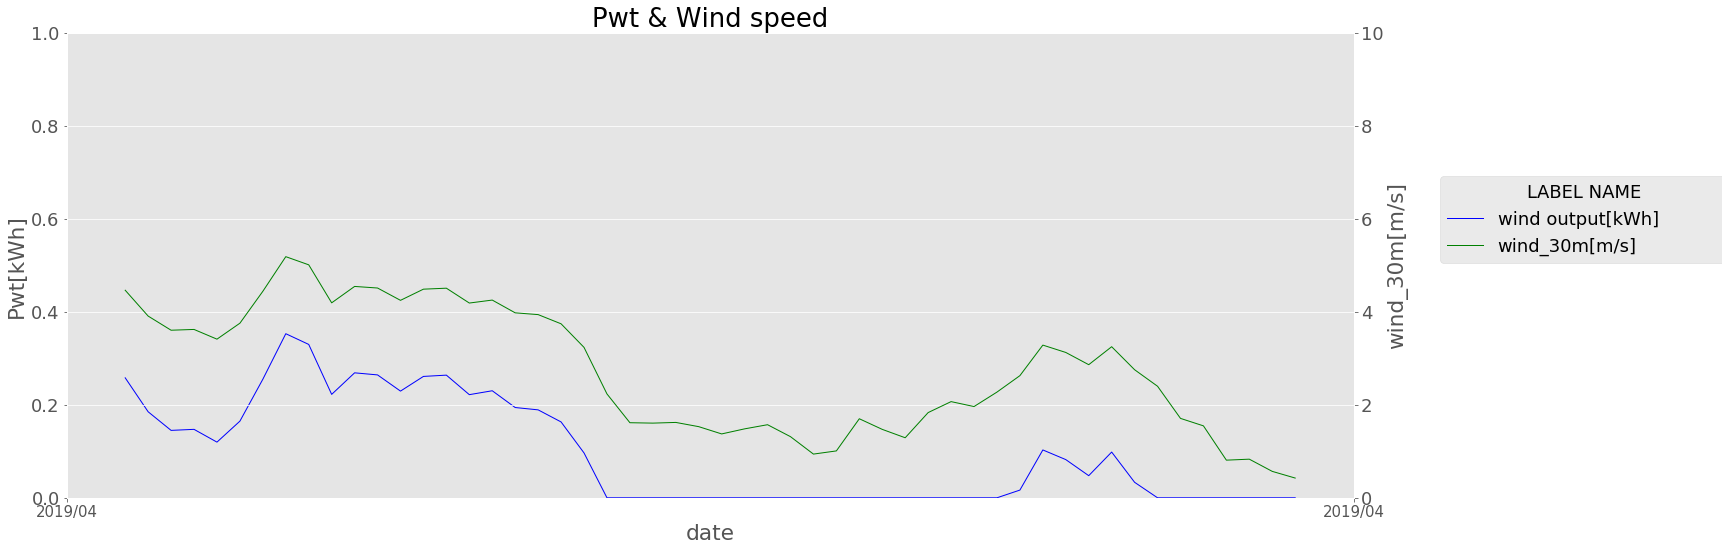

In [33]:
from matplotlib import cm
import matplotlib.dates as mdates
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

rcParams['figure.figsize'] = 20,8
plt.rcParams["font.size"] = 18


input1 = forecast['DateTime']
output1 = forecast['wind output[kWh]']
output2 = forecast['wind_30m[m/s]']

fig = plt.figure(figsize=(50,20),dpi=400)
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
ax1.plot(input1, output1, color='blue',linestyle='solid', linewidth = 1, label='wind output[kWh]')

ax1.set_ylim([0, 2])
ax2 = ax1.twinx()
ax2.plot(input1, output2, color='green', linewidth = 1, label='wind_30m[m/s]')
ax1.set_title('Pwt & Wind speed')
ax1.set_xlabel('date')
ax1.set_ylabel('Pwt[kWh]')
ax1.set_xticklabels(input1,rotation=0, size="small")
ax1.set_ylim([0, 1])
#ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))


days      = mdates.MonthLocator()  # every day
#daysFmt = mdates.DateFormatter('%Y-%m-%d')
daysFmt = mdates.DateFormatter('%Y/%m')
ax1.xaxis.set_major_locator(days)
ax1.xaxis.set_major_formatter(daysFmt)

ax2.set_ylabel('wind_30m[m/s]')
ax2.set_ylim([0, 10])


# 凡例をまとめて出力する
fig.legend(loc="lower right",
           bbox_to_anchor=(1, 0.5, 0.2, .100), 
           borderaxespad=0.,
           ncol=1,
           mode="expand",
           title="LABEL NAME"
          ) 

ax1.grid(False) #目盛のごちゃごちゃ変更

fig.show()

/home/yuichiro/miniconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


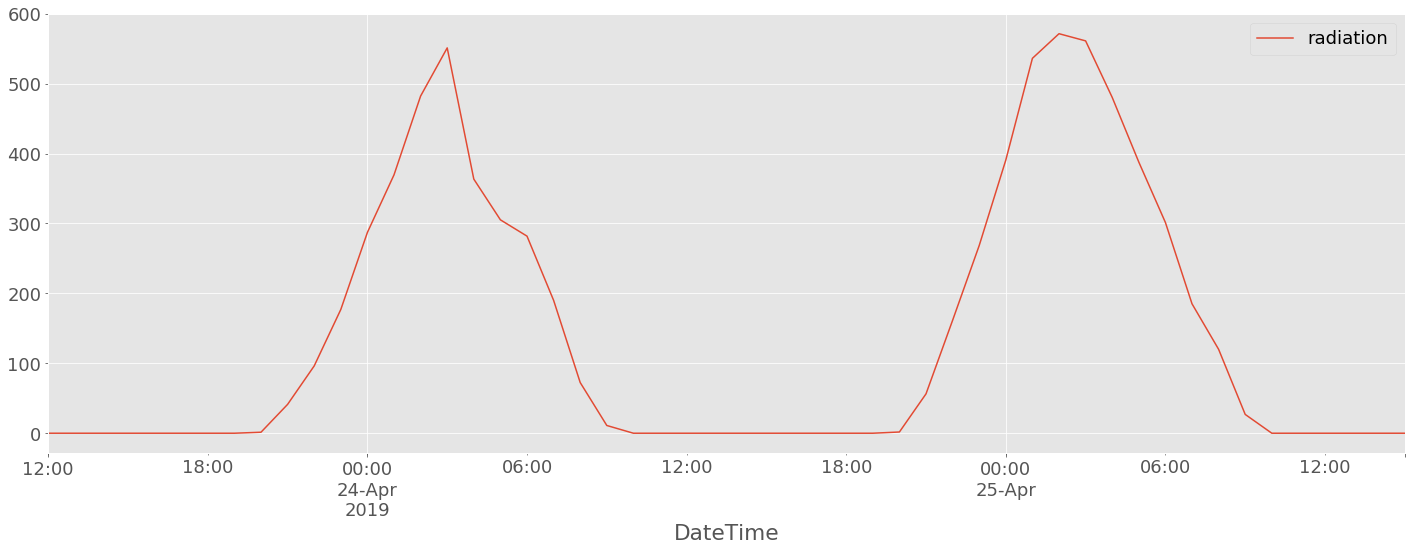

In [34]:
df.plot(y='radiation')

/home/yuichiro/miniconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


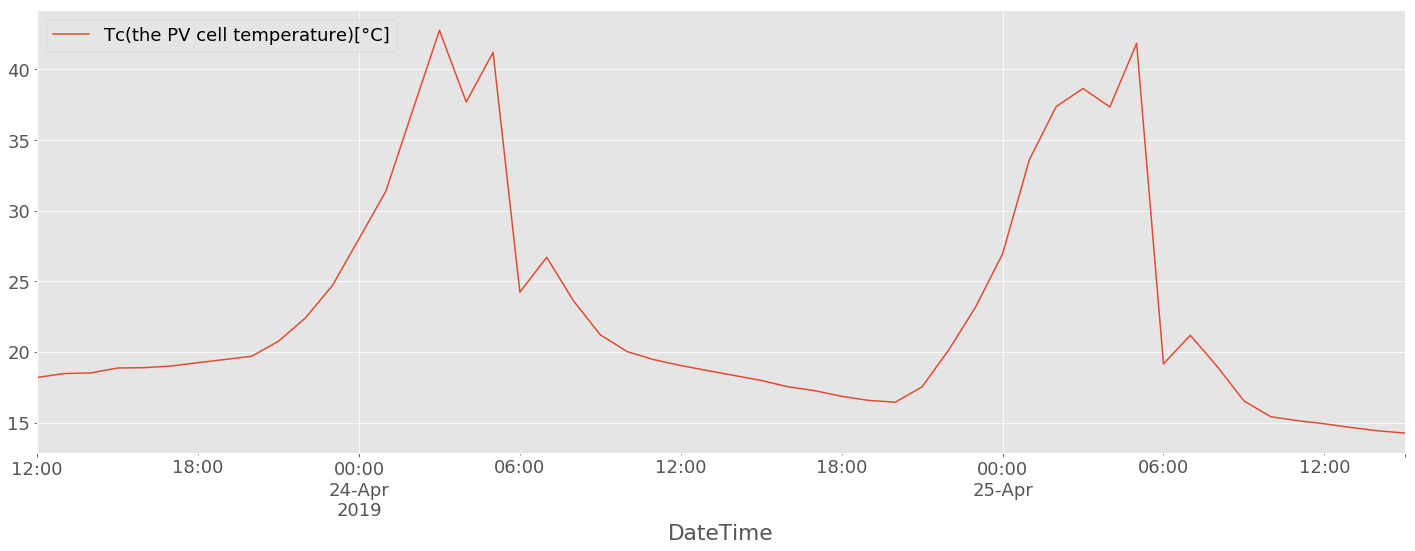

In [35]:
df.plot(y='Tc(the PV cell temperature)[°C]')

/home/yuichiro/miniconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


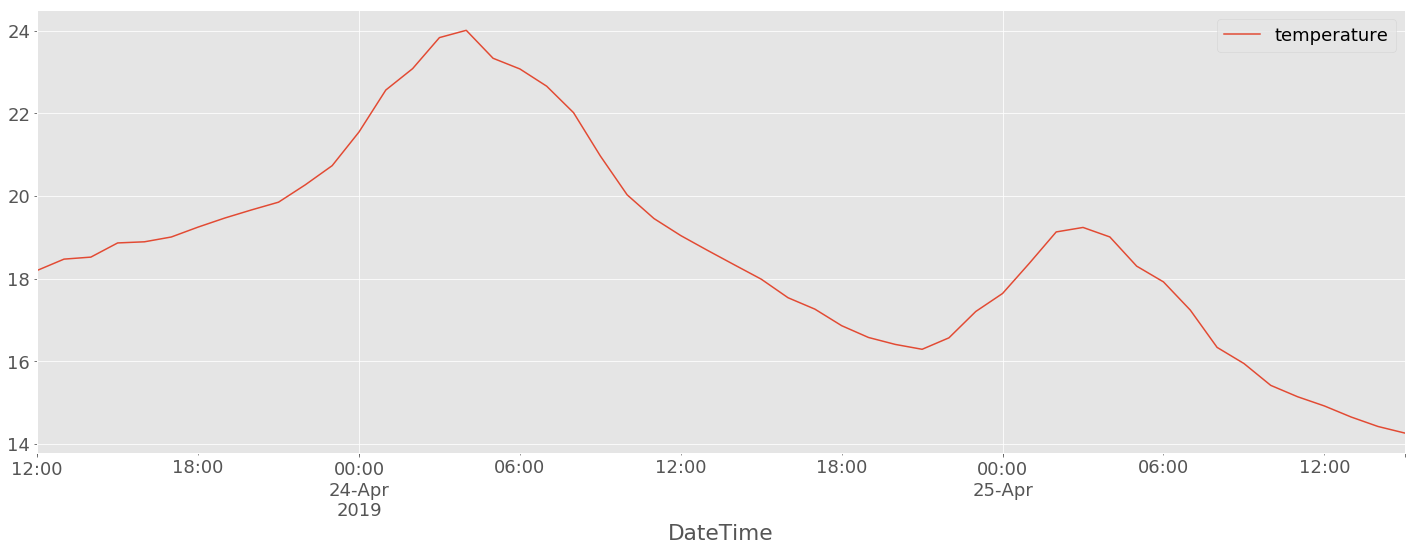

In [36]:
df.plot(y='temperature')

/home/yuichiro/miniconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


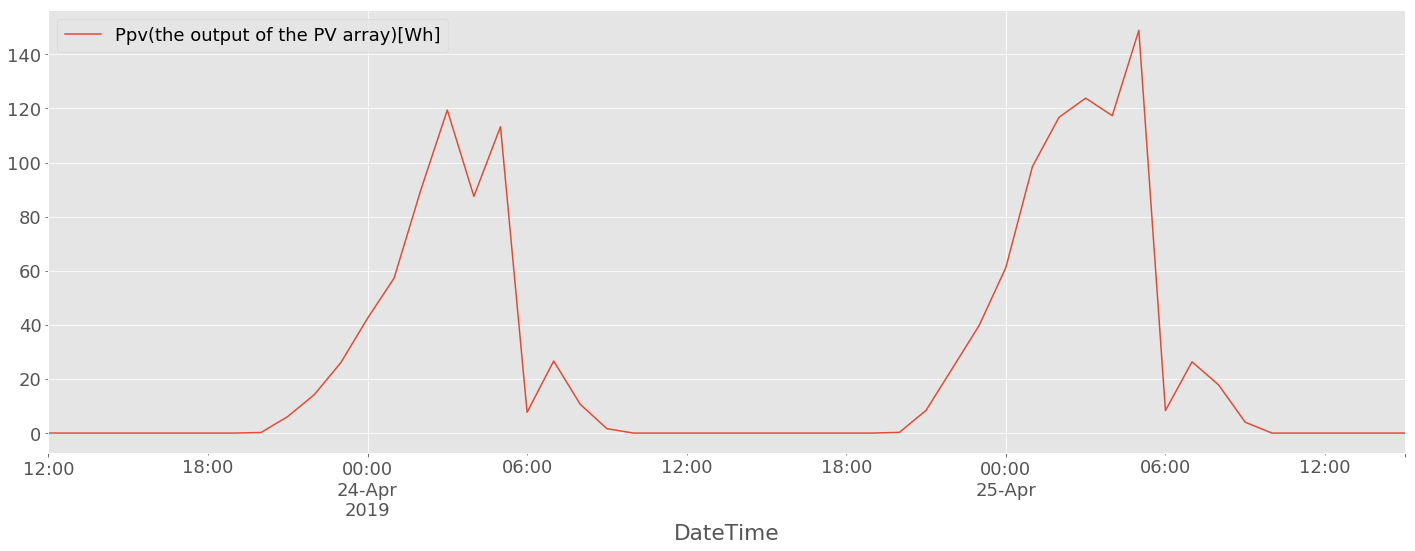

In [37]:
df.plot(y='Ppv(the output of the PV array)[Wh]')

/home/yuichiro/miniconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


<Figure size 9000x4000 with 0 Axes>

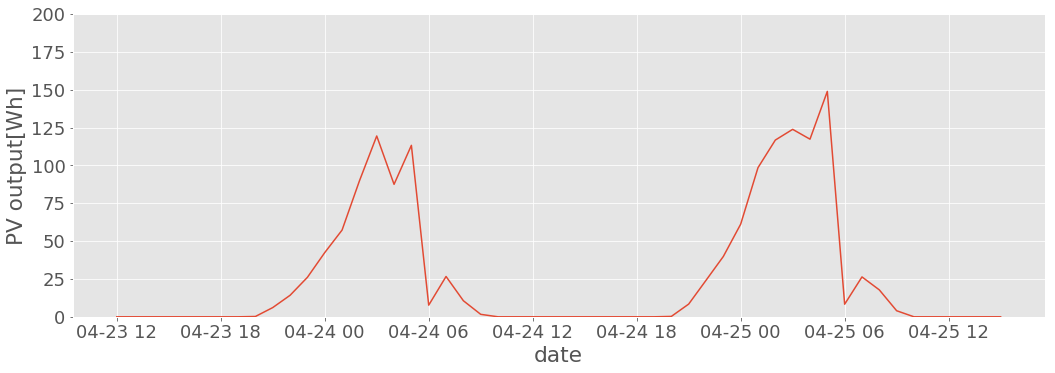

In [38]:
#df.plot(y='Ppv(the output of the PV array)[Wh]'figsize)

df3=df
rcParams['figure.figsize'] = 15,10

input1 = df3['Date']
output1 = df3['Ppv(the output of the PV array)[Wh]']

fig = plt.figure(figsize=(45,20),dpi=200)

fig = plt.figure()
df3 = fig.add_subplot(2,1,1)

df3.plot(input1, output1)

df3.set_xlabel('date')
df3.set_ylabel('PV output[Wh]')
#df3.set_xlim([0, 90000])
df3.set_ylim([0, 200])
df3.grid(True)

fig.show()

# RealTime validation

In [39]:
#################
#EveryTime check!
#################

input_data = pd.read_csv(file_dir_path+'/'+'hakata_ekimae_2019_4_22_data_from_meteoblue2.csv') #データ2

In [40]:
#列名の変更
input_data.columns = ['Year', 'Month', 'Day','Hour', 'Minute','Temperature(2m)[°C]', 'Mean Sea Level Pressure[hpa]', \
                          'Radiation[W/m2]','Wind Speed(10m)[m/s]','Wind Direction(10m)' ,'Wind Speed(80m)[m/s]'\
                  , 'Wind Direction(80m)']


#日付型などの変更
input_data['Time'] = input_data[['Year', 'Month', 'Day','Hour']].apply(lambda x: '{}@{}@{}@{}'.format(x[0], x[1], x[2],x[3]), axis=1)
Time = input_data['Time']
input_data['Time'] =pd.to_datetime(Time, format='%Y@%m@%d@%H')

In [41]:
Realtime=pd.concat([input_data],axis=1,sort=False)

In [42]:
#ωの計算
Realtime['ts'] = Realtime['Hour']
Realtime['ω'] = (Realtime['ts'].values - 12 )*15#degree
Realtime['n'] = Realtime['Time'] .dt.dayofyear
Realtime[:5]

,Year,Month,Day,Hour,Minute,Temperature(2m)[°C],Mean Sea Level Pressure[hpa],Radiation[W/m2],Wind Speed(10m)[m/s],Wind Direction(10m),Wind Speed(80m)[m/s],Wind Direction(80m),Time,ts,ω,n
0,2019,4,23,0,0,17.00,1015.7,0.0,0.76,113.20,1.88,115.20,2019-04-23 00:00:00,0,-180,113
1,2019,4,23,1,0,17.22,1015.8,0.0,0.92,130.60,1.91,137.12,2019-04-23 01:00:00,1,-165,113
2,2019,4,23,2,0,17.07,1015.8,0.0,1.35,138.01,2.30,145.62,2019-04-23 02:00:00,2,-150,113
3,2019,4,23,3,0,17.23,1015.5,0.0,1.77,137.29,2.69,138.01,2019-04-23 03:00:00,3,-135,113
4,2019,4,23,4,0,17.41,1015.3,0.0,2.05,133.03,2.70,141.01,2019-04-23 04:00:00,4,-120,113


In [43]:
Realtime['δ the solar declination']=23.45*np.sin(np.deg2rad(360*(284+Realtime['n'].values)/365))#degree

delta=Realtime['δ the solar declination'].values#degree

In [44]:
#角度をdeg2rad
omega = np.deg2rad(Realtime['ω'].values)#rad
delta =np.deg2rad(delta)#rad
phi =math.radians(phi)#rad
beta =math.radians(beta)#rad
ganma =math.radians(ganma)#rad
lam =math.radians(lam)#rad

#cosθの計算
Realtime['cosθ'] = np.sin(delta)*math.sin(phi)*math.cos(beta)\
                    -np.sin(delta)*math.cos(phi)*math.sin(beta)*math.cos(ganma)\
                    +np.cos(delta)*math.cos(phi)*math.cos(beta)*np.cos(omega)\
                    +np.cos(delta)*math.sin(phi)*math.sin(beta)*math.cos(ganma)*np.cos(omega)\
                    +np.cos(delta)*math.sin(beta)*math.sin(ganma)*np.sin(omega)
                    
cos_theta = Realtime['cosθ'].values

In [45]:
#θの計算
Realtime['θ(radian)'] = np.arccos(Realtime['cosθ'].values)#rad

Realtime['θ(degree)'] = np.rad2deg(Realtime['θ(radian)'].values)#degree

Theta_deg = Realtime['θ(radian)'].values#rad

#cosθzの計算
Realtime['cosθz'] =math.cos(phi)*np.cos(delta)*np.cos(omega)\
                        +math.sin(phi)*np.sin(delta)

cos_theta_z = Realtime['cosθz'].values

Realtime['θz(radian)'] = np.arccos(Realtime['cosθz'].values)#rad

Realtime['θz(degree)'] = np.rad2deg(Realtime['θz(radian)'].values)#degree

Theta_z_deg = Realtime['θz(radian)'].values#rad

#theta degree ndarray
theta = Realtime['θ(radian)'].values#rad

#theta degree ndarray
theta_z = Realtime['θz(radian)'].values#rad

#decimals=1で小数点第2位を四捨五入する
cos_theta = np.round(cos_theta, decimals=1)
cos_theta_z = np.round(cos_theta_z, decimals=1)
Theta_deg =np.round(Theta_deg, decimals=0)
Theta_deg_z = np.round(Theta_z_deg, decimals=0)

cos_theta = np.cos(Theta_deg)
cos_theta_z = np.cos(Theta_z_deg)
Realtime[:10]

,Year,Month,Day,Hour,Minute,Temperature(2m)[°C],Mean Sea Level Pressure[hpa],Radiation[W/m2],Wind Speed(10m)[m/s],Wind Direction(10m),...,ts,ω,n,δ the solar declination,cosθ,θ(radian),θ(degree),cosθz,θz(radian),θz(degree)
0,2019,4,23,0,0,17.00,1015.7,0.00,0.76,113.20,...,0,-180,113,12.274096,-0.977119,2.927263,167.719813,-0.974932,2.917211,167.143854
1,2019,4,23,1,0,17.22,1015.8,0.00,0.92,130.60,...,1,-165,113,12.274096,-0.943824,2.804813,160.703976,-0.941638,2.798260,160.328517
2,2019,4,23,2,0,17.07,1015.8,0.00,1.35,138.01,...,2,-150,113,12.274096,-0.846207,2.579623,147.801488,-0.844026,2.575543,147.567768
3,2019,4,23,3,0,17.23,1015.5,0.00,1.77,137.29,...,3,-135,113,12.274096,-0.690921,2.333559,133.703057,-0.688748,2.330558,133.531111
4,2019,4,23,4,0,17.41,1015.3,0.00,2.05,133.03,...,4,-120,113,12.274096,-0.488548,2.081222,119.245210,-0.486386,2.078745,119.103326
5,2019,4,23,5,0,17.17,1015.5,0.00,2.28,127.87,...,5,-105,113,12.274096,-0.252880,1.826452,104.648019,-0.250730,1.824231,104.520730
6,2019,4,23,6,0,17.20,1015.6,3.56,2.42,128.29,...,6,-90,113,12.274096,0.000023,1.570774,89.998705,0.002160,1.568637,89.876265
7,2019,4,23,7,0,19.26,1015.4,90.78,2.92,120.96,...,7,-75,113,12.274096,0.252926,1.315093,75.349304,0.255049,1.312897,75.223485
8,2019,4,23,8,0,21.98,1015.1,236.74,3.58,120.14,...,8,-60,113,12.274096,0.488593,1.060319,60.751822,0.490705,1.057897,60.613053
9,2019,4,23,9,0,23.34,1015.1,377.36,3.22,126.16,...,9,-45,113,12.274096,0.690966,0.807972,46.293361,0.693068,0.805061,46.126577


In [46]:
#Gon(the extraterrestrial normal radiation)[kW/m2]の計算
Realtime['Gon(the extraterrestrial normal radiation)[kW/m2]'] \
=Gsc*(1+0.033*np.cos(np.deg2rad(360*Realtime['n'].values/365)))#np.deg2rad

Gon =Realtime['Gon(the extraterrestrial normal radiation)[kW/m2]'].values

#Go(the extraterrestrial horizontal radiation [kW/m2])の計算
Realtime['Go(the extraterrestrial horizontal radiation)[kW/m2]'] \
=Gon*np.abs(cos_theta_z)

Go = Realtime['Go(the extraterrestrial horizontal radiation)[kW/m2]'] .values

In [47]:
#_Go(the extraterrestrial horizontal radiation averaged over the time step )[kW/m2]の計算

def step_minus(x):  #再帰関数　引数[2]-引数[1] ndarrayで返す ndarrayを引数
    x = list(x)
    y = [0]
    y.extend(x) #引数2
    x.extend([0]) #引数1
    y = np.array(y)
    x = np.array(x)
    ans = y - x
    return ans[1:]#[1:]or [:8760]


Realtime['_Go(the extraterrestrial horizontal radiation averaged over the time step )[kW/m2]'] \
=(12/np.pi)*Gon*np.abs(np.cos(phi)*np.cos(delta)*step_minus(np.sin(omega))\
+((np.pi/180)*step_minus(omega)*np.sin(phi)*np.sin(delta)))

_Go = Realtime['_Go(the extraterrestrial horizontal radiation averaged over the time step )[kW/m2]'] 

In [48]:
Realtime['the global horizontal radiation[kW/m2]']=\
Realtime['Radiation[W/m2]'].values/1000

_G = Realtime['the global horizontal radiation[kW/m2]'].values
Realtime['the global horizontal radiation[kW/m2]'] = _G 

In [49]:
#ktの計算
Realtime['kt(the clearness index)'] =_G/_Go #_G2
kt = np.abs(Realtime['kt(the clearness index)'].values)

_Go=kt/_G

#_Gdの計算
#２の３乗#累乗np.power(2, 3)
def if_kt(x):
    x = np.abs(x)
    ans = np.where(x>=0.8,0.165,np.where(x < 0.22, 1-0.09*x,0.95511-0.1604*x+4.388*x*x-16.638*x*x*x+12.336*x*x*x*x))
    return ans

Realtime['_Gd(the diffuse radiation)[kW/m2]']=_G*if_kt(kt)
_Gd = Realtime['_Gd(the diffuse radiation)[kW/m2]'].values

#_Gb(the beam radiation)の計算
Realtime['_Gb(the beam radiation)[kW/m2]']=_G-_Gd

_Gb = Realtime['_Gb(the beam radiation)[kW/m2]'].values

#_G
Realtime['_G']=_Gd+_Gb

/home/yuichiro/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [50]:
#Rbの計算
#input_data['Rb']= cos_theta/cos_theta_z
Realtime['Rb']= np.abs(Realtime['cosθ'].values/Realtime['cosθz'].values)

#thetaの計算がjupyterだとうまくいかない泣
#input_data['Rb']=Rb
Rb = Realtime['Rb'].values

#発散の処理 要考察 yを超えるとzになる　
def div(x,y,z):
    x = abs(x)
    ans = np.where(x>y,z,x)
    return ans
#Rb = div(Rb,3,3)
#input_data['Rb']= div(Rb,3,3)
Realtime['Rb']= Rb

#Afの計算
Realtime['Af']=_Gb/_Go #_G2

Af = Realtime['Af'].values

#fの計算
Realtime['f']=np.sqrt(_Gb/_G) #_G2
    #欠損値を0で置き換える
Realtime=Realtime.fillna(0)
f = Realtime['f'].values  

/home/yuichiro/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


In [51]:
def sin3(x):
    return math.sin(x)*math.sin(x)*math.sin(x)

#_Gtの計算#２の３乗#累乗np.power(2, 3) np.power(np.sin(beta/2),3) or def 3sin(x)
_Gt=(_Gb+_Gd*Af)*Rb\
                +(_Gd*(1-Af)*((1+math.cos(beta))/2)\
                *np.abs(1+f*sin3(beta/2)))\
                +(_G*rho_g*((1-math.cos(beta))/2))
_Gt[np.isnan(_Gt)] = 0
        
Realtime['_Gt']  = _Gt                     

In [52]:
#Tc(the PV cell temperature [°C])の計算
Realtime['temperature[K]']=Realtime['Temperature(2m)[°C]']+ 273.15
Ta = Realtime['temperature[K]'].values


#input_data['Tc(the PV cell temperature)[°C]']\
#= Ta+_Gt*(tau_a/UL)*(1-eta_c/tau_a)

Realtime['Tc(the PV cell temperature)[K]']\
= Ta+_Gt*((Tc_NOCT-Ta_NOCT)/Gt_NOCT)*(1-eta_c/tau_a)

Tc = Realtime['Tc(the PV cell temperature)[K]'].values

Realtime['Tc(the PV cell temperature)[°C]']=Realtime['Tc(the PV cell temperature)[K]']-273.15

#Ppv(the output of the PV array)[kW]の計算   #発散の処理div(x)を使用
#input_data['Ppv(the output of the PV array)[Wh]']\
#=div(YPV*fpv*(_Gt/_Gt_STC)*np.abs((1+ap*(Tc-Tc_STC))), YPV,YPV)

#Ppv(the output of the PV array)[kW]の計算   #発散の処理div(x)を使用2
Realtime['Ppv(the output of the PV array)[Wh]']\
=YPV*fpv*(_Gt/_Gt_STC)*np.abs((1+ap*(Tc-Tc_STC)))

Ppv = Realtime['Ppv(the output of the PV array)[Wh]'].values

#input_data['Left'] = YPV*fpv*(_Gt/_Gt_STC)
#input_data['Right'] =np.abs((1+ap*(Tc-Tc_STC)))

Realtime[:10]  

,Year,Month,Day,Hour,Minute,Temperature(2m)[°C],Mean Sea Level Pressure[hpa],Radiation[W/m2],Wind Speed(10m)[m/s],Wind Direction(10m),...,_Gb(the beam radiation)[kW/m2],_G,Rb,Af,f,_Gt,temperature[K],Tc(the PV cell temperature)[K],Tc(the PV cell temperature)[°C],Ppv(the output of the PV array)[Wh]
0,2019,4,23,0,0,17.00,1015.7,0.00,0.76,113.20,...,0.000000,0.00000,1.002244,0.000000,0.000000,0.000000,290.15,290.150000,17.000000,0.000000
1,2019,4,23,1,0,17.22,1015.8,0.00,0.92,130.60,...,0.000000,0.00000,1.002321,0.000000,0.000000,0.000000,290.37,290.370000,17.220000,0.000000
2,2019,4,23,2,0,17.07,1015.8,0.00,1.35,138.01,...,0.000000,0.00000,1.002584,0.000000,0.000000,0.000000,290.22,290.220000,17.070000,0.000000
3,2019,4,23,3,0,17.23,1015.5,0.00,1.77,137.29,...,0.000000,0.00000,1.003154,0.000000,0.000000,0.000000,290.38,290.380000,17.230000,0.000000
4,2019,4,23,4,0,17.41,1015.3,0.00,2.05,133.03,...,0.000000,0.00000,1.004445,0.000000,0.000000,0.000000,290.56,290.560000,17.410000,0.000000
5,2019,4,23,5,0,17.17,1015.5,0.00,2.28,127.87,...,0.000000,0.00000,1.008575,0.000000,0.000000,0.000000,290.32,290.320000,17.170000,0.000000
6,2019,4,23,6,0,17.20,1015.6,3.56,2.42,128.29,...,0.000007,0.00356,0.010465,0.000001,0.043186,0.003553,290.35,290.433622,17.283622,0.563735
7,2019,4,23,7,0,19.26,1015.4,90.78,2.92,120.96,...,0.001473,0.09078,0.991672,0.000742,0.127374,0.090765,292.41,294.546012,21.396012,14.250018
8,2019,4,23,8,0,21.98,1015.1,236.74,3.58,120.14,...,0.010512,0.23674,0.995696,0.008420,0.210717,0.236682,295.13,300.699919,27.549919,36.574167
9,2019,4,23,9,0,23.34,1015.1,377.36,3.22,126.16,...,0.039527,0.37736,0.996968,0.041264,0.323644,0.377192,296.49,305.366576,32.216576,57.580495


In [53]:
rf = Realtime.set_index('Time')
rf.columns

Index(['Year', 'Month', 'Day', 'Hour', 'Minute', 'Temperature(2m)[°C]',
       'Mean Sea Level Pressure[hpa]', 'Radiation[W/m2]',
       'Wind Speed(10m)[m/s]', 'Wind Direction(10m)', 'Wind Speed(80m)[m/s]',
       'Wind Direction(80m)', 'ts', 'ω', 'n', 'δ the solar declination',
       'cosθ', 'θ(radian)', 'θ(degree)', 'cosθz', 'θz(radian)', 'θz(degree)',
       'Gon(the extraterrestrial normal radiation)[kW/m2]',
       'Go(the extraterrestrial horizontal radiation)[kW/m2]',
       '_Go(the extraterrestrial horizontal radiation averaged over the time step )[kW/m2]',
       'the global horizontal radiation[kW/m2]', 'kt(the clearness index)',
       '_Gd(the diffuse radiation)[kW/m2]', '_Gb(the beam radiation)[kW/m2]',
       '_G', 'Rb', 'Af', 'f', '_Gt', 'temperature[K]',
       'Tc(the PV cell temperature)[K]', 'Tc(the PV cell temperature)[°C]',
       'Ppv(the output of the PV array)[Wh]'],
      dtype='object')

# Wind calc

In [54]:
V_COE = np.log(Realtime['Wind Speed(80m)[m/s]']/Realtime['Wind Speed(10m)[m/s]'])\
    /np.log(H_top/H_ref)


Realtime['V_COE[power law]']=V_COE
Realtime['ρ(air dencity)']=Realtime['Mean Sea Level Pressure[hpa]'] / (2.87*273.15+2.87*Realtime['Temperature(2m)[°C]'])
Realtime['Wind Speed('+str(H)+')[m/s]']=Realtime['Wind Speed(10m)[m/s]'] *(H / H_ref)**V_COE

In [55]:
wind30_values =Realtime['Wind Speed('+str(H)+')[m/s]']

Pwt=(np.where((V_rat<=wind30_values) & (wind30_values <= V_CO), Pr,\
              np.where((V_CIN<=wind30_values) & (wind30_values <= V_rat), \
                       Pr*(wind30_values-V_CIN)/(V_rat-V_CIN),0 )))
#Pwt_STP
Pwt_STP=(atm_pre0/Realtime['ρ(air dencity)'].values)*Pwt

Realtime['Pwt[kW]']= pd.Series(Pwt)
Realtime['Pwt_STP[kW]']= pd.Series(Pwt_STP)

#よく使う列だけ表示
dis = Realtime.columns.tolist()
dis = ['Time','Pwt', 'Temperature(2m)[°C]','Wind Speed('+str(H)+')[m/s]', 'Mean Sea Level Pressure[hpa]','ρ(air dencity)',\
       'Shortwave Radiation[W/m2]', 'Wind Speed(10m)[m/s]',\
       'Wind Speed(80m)[m/s]','V_COE[power law]','Pwt_STP']

# Visualize realtime

<Figure size 20000x8000 with 0 Axes>

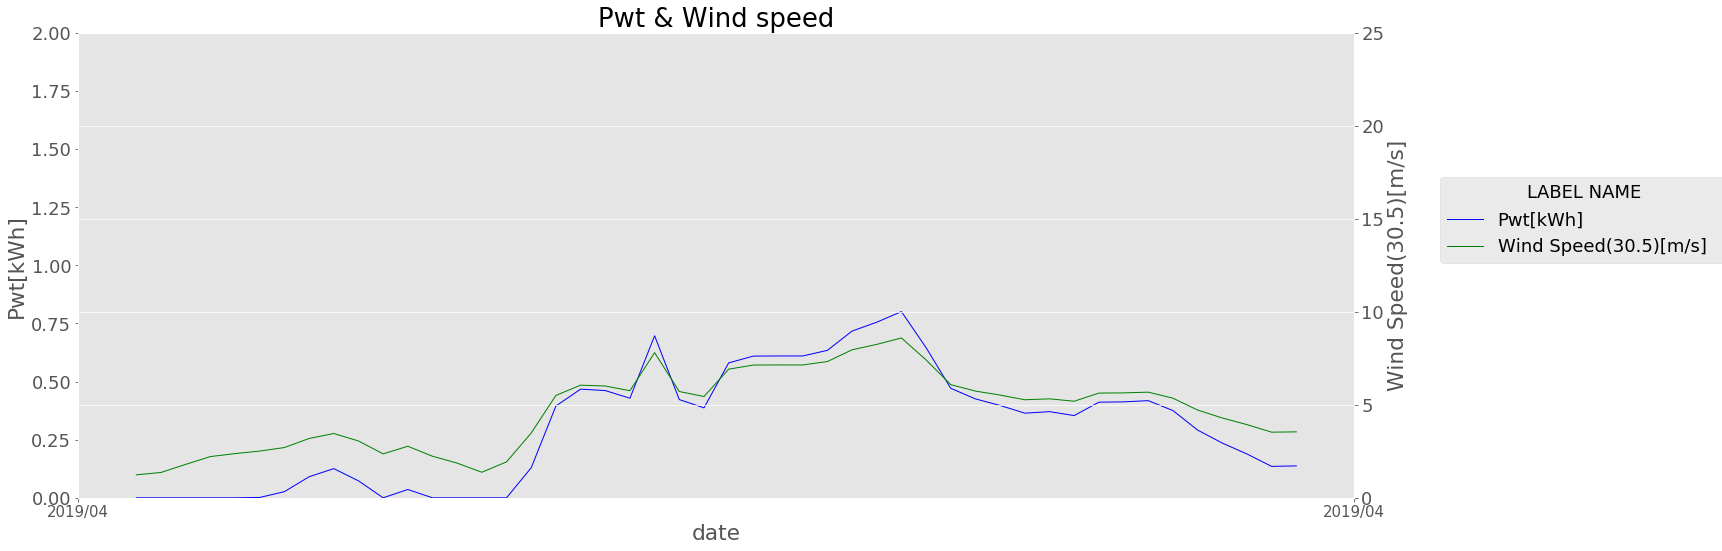

In [56]:
rcParams['figure.figsize'] = 20,8
plt.rcParams["font.size"] = 18


input1 = Realtime['Time']
output1 = Realtime['Pwt[kW]']
output2 = Realtime['Wind Speed('+str(H)+')[m/s]']

fig = plt.figure(figsize=(50,20),dpi=400)
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
ax1.plot(input1, output1, color='blue',linestyle='solid', linewidth = 1, label='Pwt[kWh]')

ax1.set_ylim([0, 2])
ax2 = ax1.twinx()
ax2.plot(input1, output2, color='green', linewidth = 1, label='Wind Speed('+str(H)+')[m/s]')
ax1.set_title('Pwt & Wind speed')
ax1.set_xlabel('date')
ax1.set_ylabel('Pwt[kWh]')
ax1.set_xticklabels(input1,rotation=0, size="small")
#ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))


days      = mdates.MonthLocator()  # every day
#daysFmt = mdates.DateFormatter('%Y-%m-%d')
daysFmt = mdates.DateFormatter('%Y/%m')
ax1.xaxis.set_major_locator(days)
ax1.xaxis.set_major_formatter(daysFmt)

ax2.set_ylabel('Wind Speed('+str(H)+')[m/s]')
ax2.set_ylim([0, 25])


# 凡例をまとめて出力する
fig.legend(loc="lower right",
           bbox_to_anchor=(1, 0.5, 0.2, .100), 
           borderaxespad=0.,
           ncol=1,
           mode="expand",
           title="LABEL NAME"
          ) 

ax1.grid(False) #目盛のごちゃごちゃ変更

fig.show()

In [57]:
df_real = Realtime.set_index('Time')
df_real.columns

Index(['Year', 'Month', 'Day', 'Hour', 'Minute', 'Temperature(2m)[°C]',
       'Mean Sea Level Pressure[hpa]', 'Radiation[W/m2]',
       'Wind Speed(10m)[m/s]', 'Wind Direction(10m)', 'Wind Speed(80m)[m/s]',
       'Wind Direction(80m)', 'ts', 'ω', 'n', 'δ the solar declination',
       'cosθ', 'θ(radian)', 'θ(degree)', 'cosθz', 'θz(radian)', 'θz(degree)',
       'Gon(the extraterrestrial normal radiation)[kW/m2]',
       'Go(the extraterrestrial horizontal radiation)[kW/m2]',
       '_Go(the extraterrestrial horizontal radiation averaged over the time step )[kW/m2]',
       'the global horizontal radiation[kW/m2]', 'kt(the clearness index)',
       '_Gd(the diffuse radiation)[kW/m2]', '_Gb(the beam radiation)[kW/m2]',
       '_G', 'Rb', 'Af', 'f', '_Gt', 'temperature[K]',
       'Tc(the PV cell temperature)[K]', 'Tc(the PV cell temperature)[°C]',
       'Ppv(the output of the PV array)[Wh]', 'V_COE[power law]',
       'ρ(air dencity)', 'Wind Speed(30.5)[m/s]', 'Pwt[kW]', 'Pwt_STP[kW]'

/home/yuichiro/miniconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


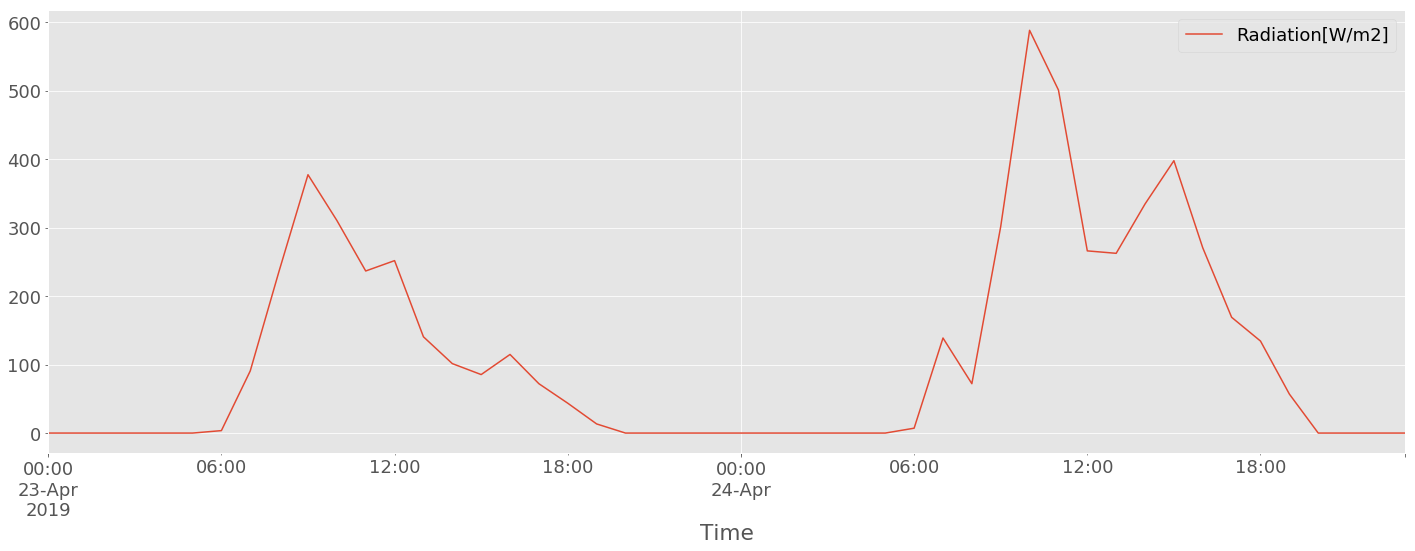

In [58]:
df_real.plot(y='Radiation[W/m2]')

/home/yuichiro/miniconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


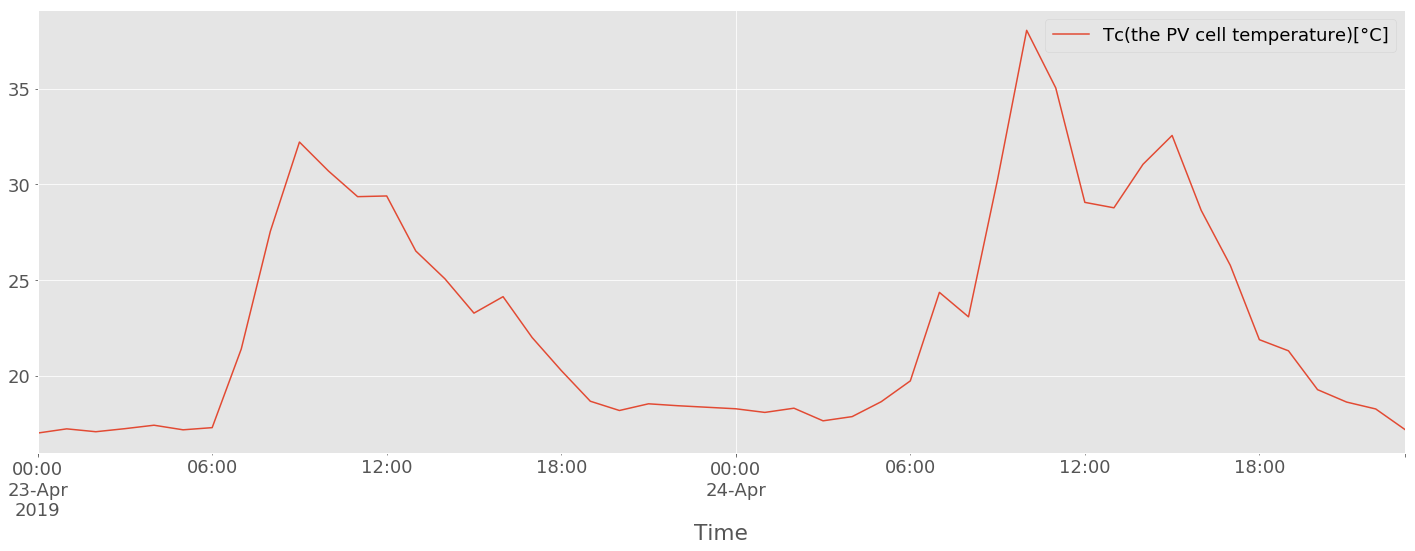

In [59]:
df_real.plot(y='Tc(the PV cell temperature)[°C]')

/home/yuichiro/miniconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


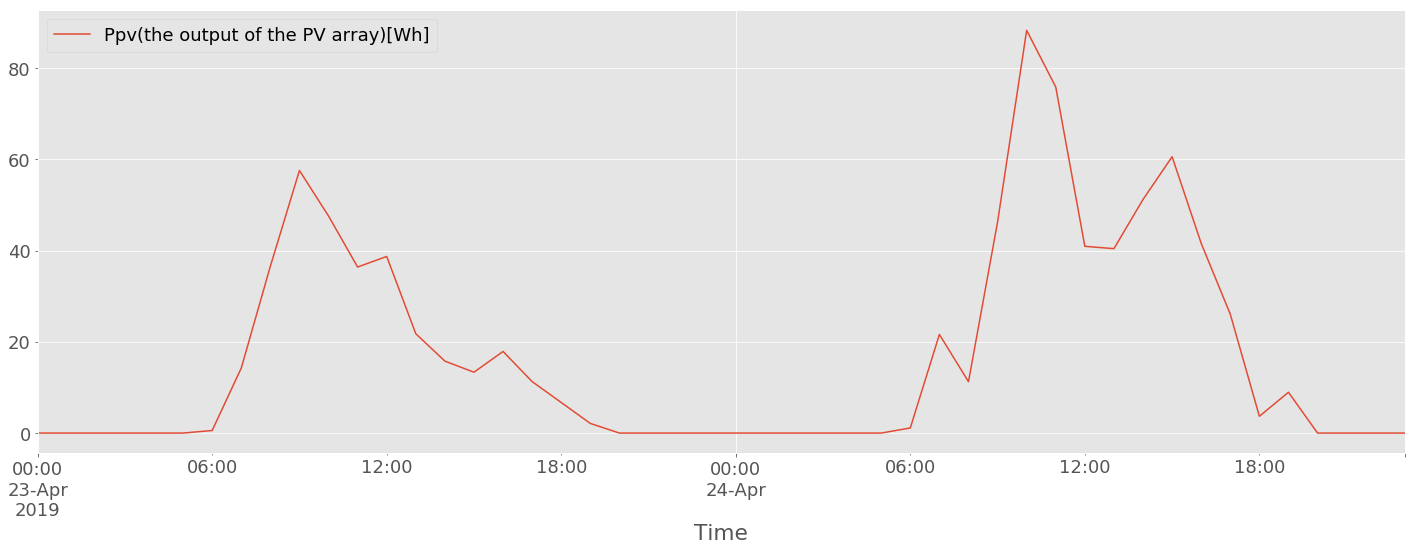

In [60]:
df_real.plot(y='Ppv(the output of the PV array)[Wh]')

In [61]:
#データの書き出し
forecast.to_csv(file_dir_path+'/PV_result_forecast.csv',encoding="UTF-8")  
Realtime.to_csv(file_dir_path+'/PV_result_realtime.csv',encoding="UTF-8")  
